# Метод главных компонент (PCA): понижение размерности на практике

В этом ноутбуке мы подробно разберём **метод главных компонент (Principal Component Analysis, PCA)**.

Цели занятия:

- Понять, **что такое понижение размерности** и зачем оно нужно в задачах анализа данных и машинного обучения.
- Интуитивно и геометрически осознать, что делает PCA на простом двумерном примере.
- Разобрать **формальное определение PCA** через ковариационную матрицу и собственные векторы.
- Применить PCA к реальному датасету рукописных цифр `digits` (64 признака).
- Посмотреть на PCA как на способ **компрессии и восстановления** изображений.
- Увидеть, как PCA можно использовать как шаг **предобработки** перед классификатором.

---

## Задача понижения размерности

Пусть есть матрица данных $X \in \mathbb{R}^{N \times d}$:

- $N$ — число объектов (строк),
- $d$ — число признаков (столбцов).

Во многих реальных задачах $d$ может быть довольно большим (десятки, сотни и более признаков), и часть этих признаков:

- сильно коррелированы друг с другом,
- содержат шум,
- не несут существенной новой информации.

**Задача понижения размерности** формулируется так:

> найти отображение
>
> $$
f : \mathbb{R}^d \to \mathbb{R}^k, \quad k < d,
$$
>
> которое переводит исходные признаки $x \in \mathbb{R}^d$ в новые признаки $z = f(x) \in \mathbb{R}^k$, > при этом стараясь **максимально сохранить важную структуру данных**.

Типичные цели понижения размерности:

- **Визуализация** высокоразмерных данных в 2D/3D.
- **Сжатие данных** (компрессия), уменьшение объёма хранения.
- **Ускорение обучения моделей**, т.к. вычислительная сложность часто растёт с размерностью.
- **Снижение шума и устранение мультиколлинеарности** (когда признаки линейно зависимы или сильно коррелированы).

Важно отличать три подхода к работе с признаками:

- **Отбор признаков (feature selection)** — выбираем подмножество исходных признаков  
  (например, оставить 10 самых информативных из 100). Сами признаки при этом не меняются.

- **Выделение новых признаков (feature extraction)** — строим новые признаки как функции от старых,  
  часто с понижением размерности. Примеры: PCA, автоэнкодеры, t-SNE/UMAP (для визуализации).

- **Ручная инженерия признаков (feature engineering)** — человек **осмысленно конструирует** новые признаки,
  опираясь на предметную область: суммы, разности, логарифмы, агрегаты, бинарные индикаторы и т.п.  
  Например, вместо «вес» и «рост» добавить признак «ИМТ», вместо временной метки — «час суток»,
  «день недели» и т.д.

В этом ноутбуке мы занимаемся именно **feature extraction** с помощью PCA:
автоматически строим новые ортогональные признаки, которые максимально сохраняют дисперсию данных.


## 1. Импорт библиотек и подготовка данных

Для иллюстраций нам понадобятся:

- Простой **искусственный 2D-датаcет**, на котором удобно показывать геометрию PCA.
- Реальный датасет `digits`, в котором каждое изображение цифры задаётся вектором длины $64$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### 1.1. Простое 2D-облако точек

Сгенерируем облако точек в $\mathbb{R}^2$ и применим к нему линейное преобразование, чтобы получить вытянутую и наклонённую структуру. На таком примере удобно показывать, как PCA находит направление максимальной дисперсии.

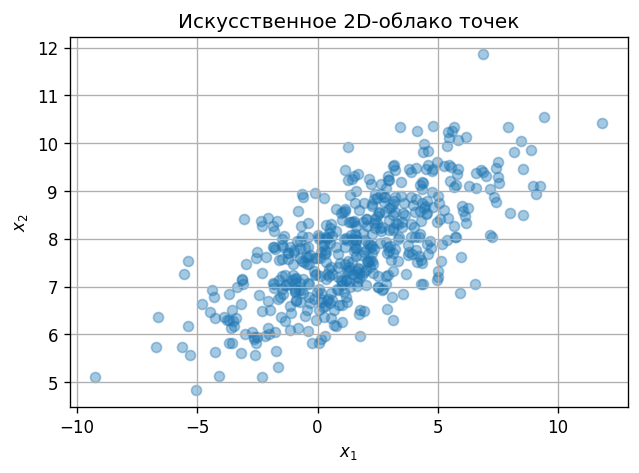

In [2]:
from sklearn.datasets import make_blobs

X_2d, _ = make_blobs(n_samples=500, centers=1, random_state=RANDOM_STATE)

# Линейное преобразование для создания наклонного вытянутого облака
A = np.array([[3.0, 1.0],
              [0.5, 1.0]])
X_2d = X_2d @ A.T

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.4)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Искусственное 2D-облако точек')
plt.grid(True)
plt.show()

### 1.2. Датасет `digits` (рукописные цифры)

Датасет `digits` — это мини-версия задачи распознавания цифр:

- каждый объект — изображение цифры размером $8 \times 8$ пикселей;
- каждый пиксель — признак (значение от 0 до 16);
- итоговый признак вектор имеет размерность $64$.

А значит, у нас есть **64-мерное признаковое пространство**, которое удобно сжать и визуализировать с помощью PCA.

In [3]:
digits = load_digits()
X_digits = digits.data  # (n_samples, 64)
y_digits = digits.target

print('Форма матрицы признаков:', X_digits.shape)
print('Метки классов:', np.unique(y_digits))

Форма матрицы признаков: (1797, 64)
Метки классов: [0 1 2 3 4 5 6 7 8 9]


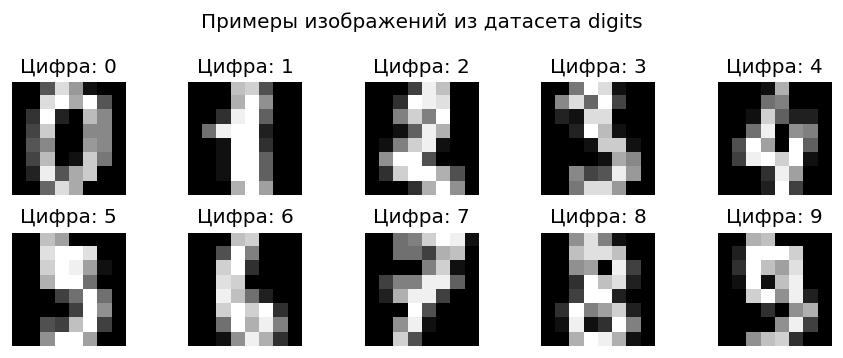

In [4]:
# Визуализируем несколько примеров цифр
n_rows, n_cols = 2, 5
plt.figure(figsize=(1.5 * n_cols, 1.5 * n_rows))
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.imshow(X_digits[i].reshape(8, 8), interpolation='nearest', cmap='gray')
    ax.set_title(f'Цифра: {y_digits[i]}')
    ax.axis('off')
plt.suptitle('Примеры изображений из датасета digits')
plt.tight_layout()
plt.show()

## 2. Интуиция PCA на простом 2D-примере

Начнём с двумерного случая, где всё можно увидеть глазами.

Интуитивная идея PCA:

1. Представьте себе облако точек в $\mathbb{R}^2$.
2. Мы хотим найти **ось**, вдоль которой данные разбросаны сильнее всего — это первая главная компонента $w_1$.
3. Вторая компонента $w_2$ перпендикулярна первой и объясняет максимально возможную дисперсию в оставшемся направлении.

В 2D это выглядит как выбор новой системы координат $(\text{PC1}, \text{PC2})$, ориентированной вдоль длинной и короткой оси облака точек.

### 2.1. Вычисление главных компонент в 2D

Используем `sklearn.decomposition.PCA`, чтобы найти направления главных компонент и дисперсию, которую они объясняют. Для чистоты эксперимента явно вычтем среднее (центрируем данные).

In [5]:
# Центрирование данных (PCA в sklearn делает это автоматически, но для наглядности сделаем это явно)
X_2d_mean = X_2d.mean(axis=0)
X_2d_centered = X_2d - X_2d_mean

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
pca_2d.fit(X_2d_centered)

print('Компоненты PCA (строки):')
print(pca_2d.components_)
print('Объяснённая дисперсия по компонентам:')
print(pca_2d.explained_variance_)

Компоненты PCA (строки):
[[ 0.96649837  0.25667274]
 [-0.25667274  0.96649837]]
Объяснённая дисперсия по компонентам:
[9.91137003 0.5829574 ]


Строки в `pca_2d.components_` — это векторы $w_1$ и $w_2$, задающие направления главных компонент. Значения в `explained_variance_` — это оценки $\lambda_1$ и $\lambda_2$, то есть дисперсия данных вдоль этих направлений.

Чем больше $\lambda_i$, тем больше вариации вдоль соответствующей компоненты и тем "важнее" она считается.

### 2.2. Визуализация главных компонент

Нарисуем исходное облако точек (после центрирования) и стрелки, соответствующие главным компонентам. Таким образом можно увидеть, как PCA подбирает новую систему координат, согласованную с формой облака.

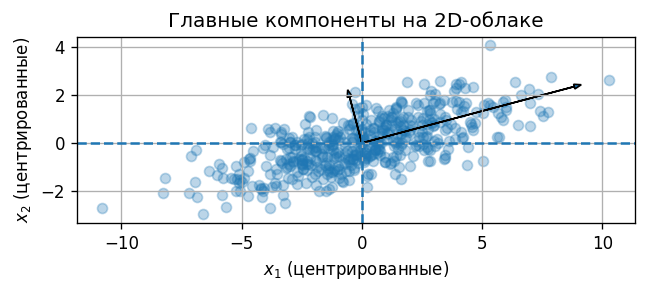

In [6]:
components = pca_2d.components_
variances = pca_2d.explained_variance_

plt.figure()
plt.scatter(X_2d_centered[:, 0], X_2d_centered[:, 1], alpha=0.3)

# Рисуем векторы главных компонент из начала координат
for length, vector in zip(variances, components):
    v = vector * np.sqrt(length) * 3.0  # масштабируем для наглядности
    plt.arrow(0.0, 0.0, v[0], v[1],
              head_width=0.2, length_includes_head=True)

plt.axhline(0.0, linestyle='--')
plt.axvline(0.0, linestyle='--')
plt.xlabel('$x_1$ (центрированные)')
plt.ylabel('$x_2$ (центрированные)')
plt.title('Главные компоненты на 2D-облаке')
plt.grid(True)
plt.gca().set_aspect('equal', 'box')
plt.show()

Первая компонента (стрелка большей длины) направлена вдоль "длинной" оси облака — именно там данные имеют наибольший разброс (дисперсию). Вторая компонента перпендикулярна первой и соответствует направлению меньшей дисперсии.

### 2.3. Проекция на первую компоненту и восстановление

Часто PCA используют для **уменьшения размерности**: вместо $d$ компонент оставляют только первые $k < d$. В 2D это означает, что мы можем оставить только первую компоненту $w_1$ и отбросить вторую.

Фактически это означает проекцию всех точек на прямую, задаваемую $w_1$. Давайте посмотрим, как выглядят исходные точки и восстановленные из одной компоненты.

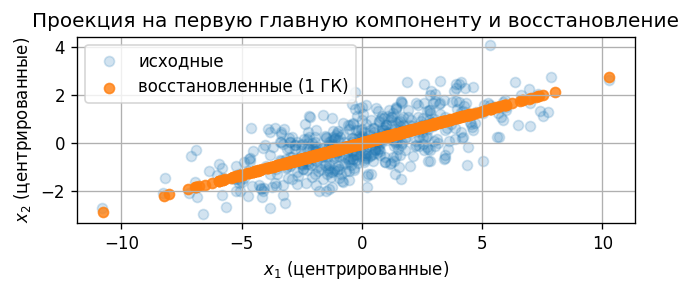

In [7]:
pca_1d = PCA(n_components=1, random_state=RANDOM_STATE)
X_1d = pca_1d.fit_transform(X_2d_centered)              # координаты вдоль первой ГК
X_1d_recon = pca_1d.inverse_transform(X_1d)             # восстановленные точки в 2D

plt.figure()
plt.scatter(X_2d_centered[:, 0], X_2d_centered[:, 1], alpha=0.2, label='исходные')
plt.scatter(X_1d_recon[:, 0], X_1d_recon[:, 1], alpha=0.8, label='восстановленные (1 ГК)')
plt.xlabel('$x_1$ (центрированные)')
plt.ylabel('$x_2$ (центрированные)')
plt.title('Проекция на первую главную компоненту и восстановление')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', 'box')
plt.show()

Все восстановленные точки лежат на одной прямой: мы фактически **сжали** облако до одномерного множества. При этом:

- сохранили вариацию вдоль главной оси облака;
- полностью потеряли информацию о разбросе в перпендикулярном направлении.

Это и есть ключевая идея PCA: попытаться сохранить как можно больше дисперсии данных при снижении размерности.

## 3. Формальное определение PCA

Пусть есть матрица центрированных данных $\tilde{X} \in \mathbb{R}^{N \times d}$ (из каждого признака вычтено среднее):

$$
\tilde{X} = X - \mathbf{1} \mu^\top,
$$

где $\mu \in \mathbb{R}^d$ — вектор средних по столбцам, $\mathbf{1} \in \mathbb{R}^{N \times 1}$ — столбец из единиц.

Определим **ковариационную матрицу** признаков:

$$
S = \frac{1}{N} \tilde{X}^\top \tilde{X} \in \mathbb{R}^{d \times d}.
$$

Задача PCA формулируется как поиск ортонормированных векторов $w_1, \dots, w_d$ (главных компонент), которые являются собственными векторами ковариационной матрицы:

$$
S w_i = \lambda_i w_i,
$$

где $\lambda_i$ — собственное значение, равное дисперсии проекций данных на направление $w_i$:

$$
\lambda_i = \mathrm{Var}(\tilde{X} w_i).
$$

Собственные значения упорядочиваются по убыванию:

$$
\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_d.
$$

Тогда первая главная компонента $w_1$ — это направление, вдоль которого данные имеют наибольшую дисперсию, вторая компонента $w_2$ — направление максимальной дисперсии в ортогональном подпространстве и т.д.

Если мы хотим перейти к пространству размерности $k < d$, берём первые $k$ главных компонент и собираем матрицу

$$
W_k = [w_1, w_2, \dots, w_k] \in \mathbb{R}^{d \times k}.
$$

Новые признаки (главные компоненты) для всех объектов:

$$
Z = \tilde{X} W_k, \quad Z \in \mathbb{R}^{N \times k}.
$$

Доля дисперсии, объяснённой $i$-й компонентой, равна

$$
\text{EVR}_i = \frac{\lambda_i}{\sum_{j=1}^d \lambda_j}.
$$

Эти величины в `sklearn` доступны как `explained_variance_` и `explained_variance_ratio_`. На практике в `PCA` используется SVD, но концептуально модель эквивалентна описанному выше разложению.

## 4. PCA на датасете рукописных цифр `digits`

Перейдём к реальному высокоразмерному датасету. Каждая цифра описывается вектором длины $64$, и мы хотим:

- **визуализировать** данные в 2D (используя первые две главные компоненты);
- понять, сколько компонент нужно, чтобы объяснить большую часть дисперсии.

Перед PCA обычно выполняют **масштабирование признаков**, чтобы признаки с большими масштабами не доминировали в дисперсии:

- приведём каждый признак к нулевому среднему и единичному стандартному отклонению с помощью `StandardScaler`.

In [8]:
scaler = StandardScaler()
X_digits_scaled = scaler.fit_transform(X_digits)

pca_digits_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_digits_pca2 = pca_digits_2d.fit_transform(X_digits_scaled)

print('Форма данных после PCA (2 компоненты):', X_digits_pca2.shape)

Форма данных после PCA (2 компоненты): (1797, 2)


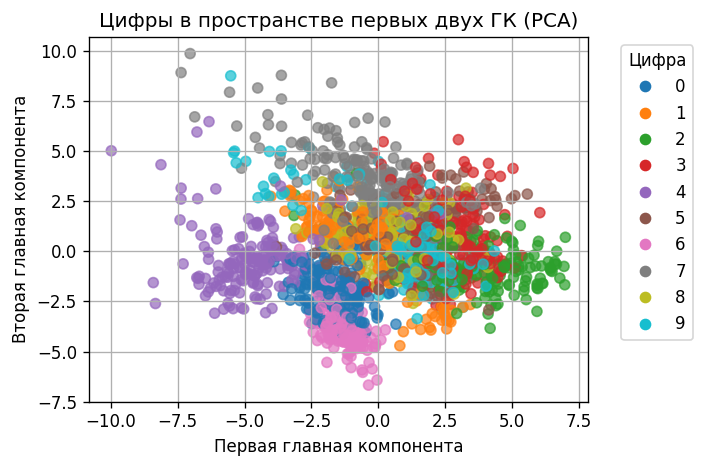

In [20]:
plt.figure()

scatter = plt.scatter(
    X_digits_pca2[:, 0],
    X_digits_pca2[:, 1],
    c=y_digits,
    alpha=0.7,
    cmap="tab10"  # дискретная палитра из 10 цветов
)

plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Цифры в пространстве первых двух ГК (PCA)')
plt.grid(True)

# Создаём легенду по классам
classes = np.unique(y_digits)
handles = []

for cls in classes:
    # Берём цвет из той же colormap, что и scatter
    color = scatter.cmap(scatter.norm(cls))
    handle = plt.Line2D(
        [], [], marker='o', linestyle='',
        color=color, label=str(cls)
    )
    handles.append(handle)

plt.legend(
    handles=handles,
    title='Цифра',
    bbox_to_anchor=(1.05, 1.0),
    loc='upper left'
)

plt.tight_layout()
plt.show()

Каждая точка на графике — это одно изображение цифры, спроецированное на первые две главные компоненты. Цвет точки соответствует истинной цифре $y \in \{0, \dots, 9\}$.

Можно увидеть, что многие цифры образуют более-менее компактные кластеры, но пересечения между классами сохраняются. PCA максимизирует variance, а не напрямую качество разделения классов, однако часто первые компоненты уже дают некоторую структуру данных.

### 4.1. Объяснённая дисперсия и выбор числа компонент

Посмотрим, какую долю дисперсии объясняет каждая главная компонента, и как растёт накопленная доля дисперсии в зависимости от числа компонент.

In [10]:
pca_digits_full = PCA(random_state=RANDOM_STATE)
pca_digits_full.fit(X_digits_scaled)

explained_variance_ratio = pca_digits_full.explained_variance_ratio_
cumulative_evr = np.cumsum(explained_variance_ratio)

print('Первые 10 долей объяснённой дисперсии:')
print(explained_variance_ratio[:10])

Первые 10 долей объяснённой дисперсии:
[0.12033916 0.09561054 0.08444415 0.06498408 0.04860155 0.0421412
 0.03942083 0.03389381 0.02998221 0.02932003]


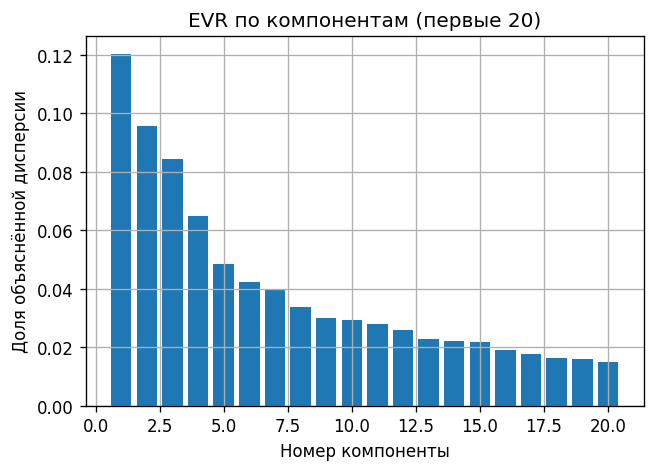

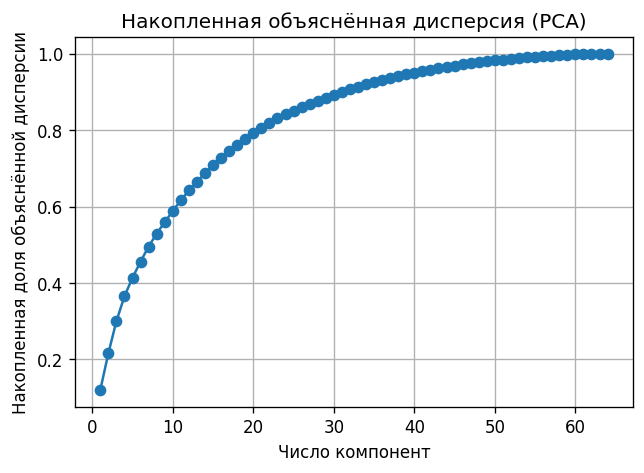

In [11]:
# График долей объяснённой дисперсии по компонентам (первые 20)
n_show = 20
plt.figure()
plt.bar(range(1, n_show + 1), explained_variance_ratio[:n_show])
plt.xlabel('Номер компоненты')
plt.ylabel('Доля объяснённой дисперсии')
plt.title('EVR по компонентам (первые 20)')
plt.grid(True)
plt.show()

# График накопленной доли дисперсии
plt.figure()
plt.plot(range(1, len(cumulative_evr) + 1), cumulative_evr, marker='o')
plt.xlabel('Число компонент')
plt.ylabel('Накопленная доля объяснённой дисперсии')
plt.title('Накопленная объяснённая дисперсия (PCA)')
plt.grid(True)
plt.show()

По графику накопленной доли дисперсии можно выбирать число компонент $k$ по принципу:

$$
\sum_{i=1}^k \text{EVR}_i \geq \alpha,
$$

где $\alpha$ — целевая доля (например, $0.9$ или $0.95$). Так мы получаем компромисс между сохранением информации и уменьшением размерности: чем больше $k$, тем больше информации сохраняем, но тем выше размерность нового пространства.

## 5. PCA как компрессия: восстановление изображений цифр

Теперь посмотрим на PCA как на способ **компрессии изображений**:

1. Мы будем сохранять только первые $k$ главных компонент.
2. По этим $k$ координатам попытаемся приблизительно восстановить исходные изображения.

Формально, если мы оставляем $k$ компонент:

- исходные центрированные данные: $\tilde{X}$;
- матрица компонент: $W_k$ (первые $k$ столбцов);
- новые признаки: $Z = \tilde{X} W_k$;
- восстановление (приближённое):

$$
\hat{X} \approx Z W_k^\top + \mu^\top.
$$

В `sklearn` методы `transform` и `inverse_transform` реализуют этот переход и обратное преобразование автоматически.

In [12]:
def reconstruct_digits_with_pca(n_components, X, scaler):
    """Выполнить PCA с n_components и восстановить изображения.

    X — исходные данные (без масштабирования),
    scaler — уже обученный StandardScaler.
    """
    X_scaled_local = scaler.transform(X)
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_proj = pca.fit_transform(X_scaled_local)
    X_recon_scaled = pca.inverse_transform(X_proj)
    X_recon = scaler.inverse_transform(X_recon_scaled)
    return X_recon

# Выберем несколько значений числа компонент
components_list = [5, 10, 20, 40]

# Возьмём несколько первых изображений для демонстрации
n_images = 5
indices = np.arange(n_images)

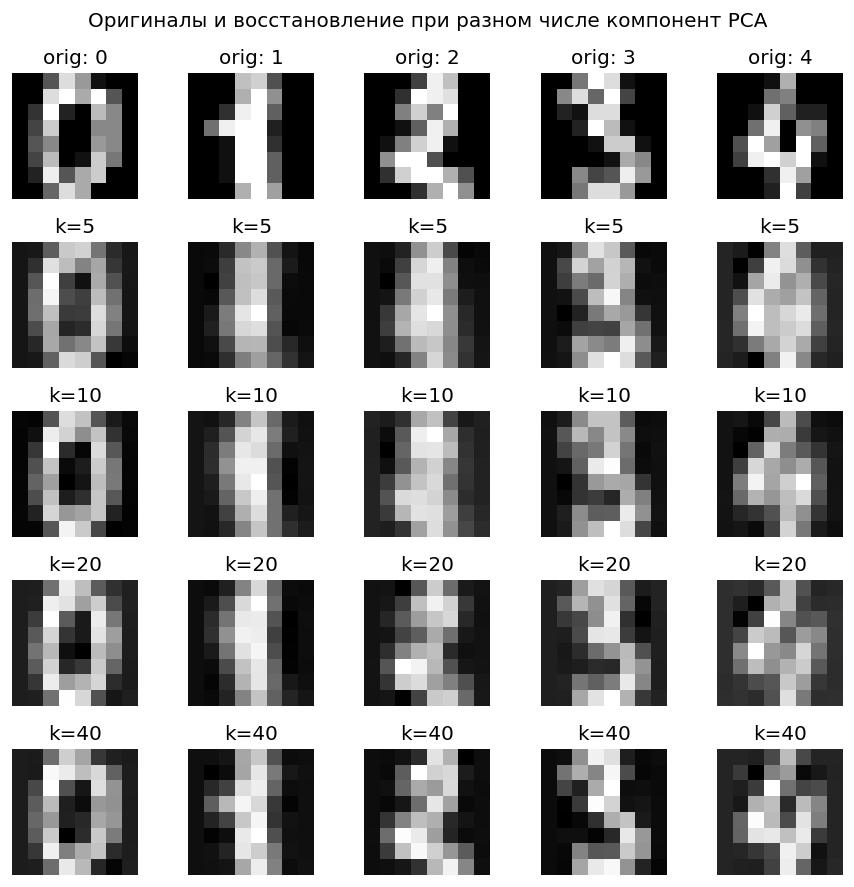

In [13]:
fig, axes = plt.subplots(len(components_list) + 1, n_images,
                         figsize=(1.5 * n_images, 1.5 * (len(components_list) + 1)))

# Первая строка — оригиналы
for j, idx in enumerate(indices):
    ax = axes[0, j]
    ax.imshow(X_digits[idx].reshape(8, 8), interpolation='nearest', cmap='gray')
    ax.set_title(f'orig: {y_digits[idx]}')
    ax.axis('off')

# Остальные строки — восстановление с разными k
for i, n_comp in enumerate(components_list, start=1):
    X_recon = reconstruct_digits_with_pca(n_comp, X_digits, scaler)
    for j, idx in enumerate(indices):
        ax = axes[i, j]
        ax.imshow(X_recon[idx].reshape(8, 8), interpolation='nearest', cmap='gray')
        ax.set_title(f'k={n_comp}')
        ax.axis('off')

plt.suptitle('Оригиналы и восстановление при разном числе компонент PCA')
plt.tight_layout()
plt.show()

In [14]:
# Оценим среднеквадратичную ошибку восстановления для разных k
mse_values = []
for n_comp in components_list:
    X_recon = reconstruct_digits_with_pca(n_comp, X_digits, scaler)
    mse = mean_squared_error(X_digits, X_recon)
    mse_values.append((n_comp, mse))

for n_comp, mse in mse_values:
    print(f'n_components = {n_comp:2d}, MSE восстановления = {mse:.4f}')

n_components =  5, MSE восстановления = 9.4392
n_components = 10, MSE восстановления = 6.5493
n_components = 20, MSE восстановления = 3.7595
n_components = 40, MSE восстановления = 1.0814


Наблюдения:

- При очень малом числе компонент (например, $k=5$) изображения становятся сильно размытыми, но общая форма цифры всё ещё узнаваема.
- При увеличении числа компонент качество восстановления заметно улучшается.
- При достаточно большом $k$ (например, $k=40$) восстановленные изображения визуально почти не отличаются от исходных, хотя размерность признакового описания уже значительно меньше исходных $64$.

Среднеквадратичная ошибка (MSE) даёт численную меру качества восстановления для каждого $k$.

## 6. PCA как шаг предобработки перед классификацией

Наконец, рассмотрим PCA как часть **ML-пайплайна**:

- сначала уменьшим размерность признаков с помощью PCA;
- затем обучим классификатор (логистическую регрессию);
- сравним качество с моделью без PCA.

В реальных задачах такой подход используется для:

- ускорения обучения на больших признаковых пространствах,
- устранения мультиколлинеарности,
- уменьшения влияния шума в признаках.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=RANDOM_STATE, stratify=y_digits
)

# Масштабируем отдельно train и применяем тот же scaler к test
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

# Базовая модель без PCA
base_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
base_clf.fit(X_train_scaled, y_train)
y_pred_base = base_clf.predict(X_test_scaled)
acc_base = accuracy_score(y_test, y_pred_base)
print(f'Без PCA, accuracy = {acc_base:.4f}')

Без PCA, accuracy = 0.9722


In [16]:
# Модели с PCA: будем менять число компонент
components_grid = [5, 10, 15, 20, 30, 40, 50, 64]
results = []

for n_comp in components_grid:
    pca_clf = PCA(n_components=n_comp, random_state=RANDOM_STATE)
    X_train_pca = pca_clf.fit_transform(X_train_scaled)
    X_test_pca = pca_clf.transform(X_test_scaled)

    clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    results.append((n_comp, acc))

df_results = pd.DataFrame(results, columns=['n_components', 'accuracy'])
df_results

,n_components,accuracy
0,5,0.805556
1,10,0.877778
2,15,0.930556
3,20,0.941667
4,30,0.955556
5,40,0.952778
6,50,0.966667
7,64,0.972222


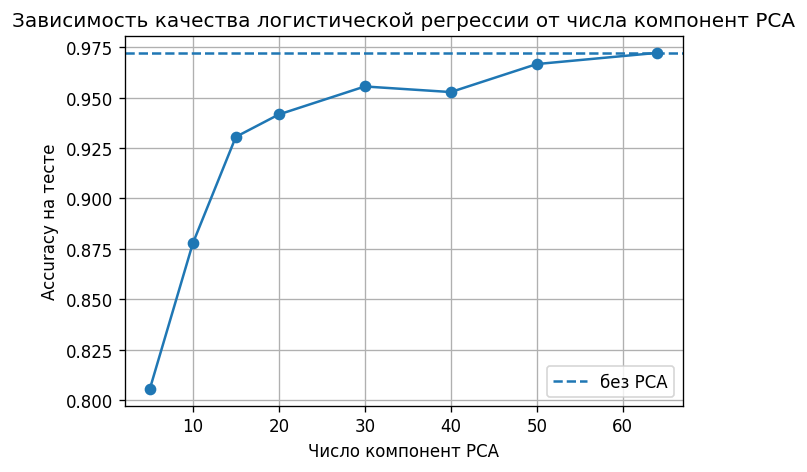

In [17]:
plt.figure()
plt.plot(df_results['n_components'], df_results['accuracy'], marker='o')
plt.axhline(acc_base, linestyle='--', label='без PCA')
plt.xlabel('Число компонент PCA')
plt.ylabel('Accuracy на тесте')
plt.title('Зависимость качества логистической регрессии от числа компонент PCA')
plt.legend()
plt.grid(True)
plt.show()

Из графика видно типичное поведение:

- при очень малом числе компонент качество ниже (мы слишком сильно сжали данные и потеряли важную информацию);
- по мере увеличения числа компонент accuracy растёт и может приблизиться к качеству модели без PCA;
- начиная с некоторого $k$, добавление новых компонент почти не улучшает качество.

На практике число компонент $k$ часто выбирают, комбинируя два критерия:

- доля объяснённой дисперсии (например, не менее $90\%$);
- качество на валидационной выборке (accuracy, F1 и т.п.).